In [24]:
from tensorflow.keras.models import load_model

In [25]:
generator = load_model('saved_model/generatorwgan_train_obj.h5')
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 6, 1280)]    0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 5, 6)]       0           []                               
                                                                                                  
 tf.__operators__.getitem_51 (S  (None, 1280)        0           ['input_14[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_53 (S  (None, 6)           0           ['input_15[0][0]']         

In [26]:
discriminator = load_model('saved_model/discriminatorwgan_train_no_obj.h5')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 6, 3, 64, 64)]    0         
                                                                 
 conv3d_12 (Conv3D)          (None, 6, 3, 64, 4)       6916      
                                                                 
 conv3d_13 (Conv3D)          (None, 3, 2, 32, 4)       436       
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 dense_51 (Dense)            (None, 512)               393728    
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 512)             

In [27]:
from src.wgan import WassersteinGAN

len_input_seq = 6
len_generated_seq = 6

gan = WassersteinGAN(
    generator=generator,
    discriminator=discriminator,
    len_input_seq=len_input_seq,
    len_generated_seq=len_generated_seq,
    patience=3,
    learning_rate_generator=0.005,
    learning_rate_discriminator=0.01,
    n_critic=5,  # number of critic updates per generator update
    clip_value=0.01,
    discriminator_gradient_penalty_weight=0.02,
    generator_wloss_weight=0.2,
    generator_flow_loss_weight=0.15,
    generator_mse_weight=0.6,
    color_weight=0.05,
    save_path = 'wgan_train_obj'
)

In [28]:
def get_data():
    import pickle

    with open('data/new_data_obj.pkl', 'rb') as f:
        X_train, cX_train, X_train_z = pickle.load(f)

    # split the training set into training and validation
    n_sample_train = int(X_train.shape[0] * 0.8)

    X_train, X_val = X_train[:n_sample_train], X_train[n_sample_train:]
    cX_train, cX_val = cX_train[:n_sample_train], cX_train[n_sample_train:]
    X_train_z, X_val_z = X_train_z[:n_sample_train], X_train_z[n_sample_train:]

    len_input_seq = X_train.shape[1] # 6
    len_generated_seq = 12

    return X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq

X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq = get_data()

### Recursive predictions

In [ ]:
from skimage import img_as_ubyte
import imageio
import numpy as np

def generate_gif(images, name):
    images = [img_as_ubyte(image) for image in images]
    images = [np.transpose(image, (1, 2, 0)) for image in images]
    imageio.mimsave(f'{name}.gif', images)

def generate_gif_gray(images, name):
    images = [img_as_ubyte(image) for image in images]
    imageio.mimsave(f'{name}.gif', images)

for i in range(0, X_val.shape[0]):
    X = X_val[i]
    z = X_val_z[i]
    cX = cX_val[i]

    generated_images = gan.generate(X, z, cX)[0]
    images_list = gan.generate(generated_images, z, cX)[0]

    images_list = np.concatenate((X, images_list), axis=0)

    # image to gray scale
    images_list_bw = np.zeros((images_list.shape[0], images_list.shape[2], images_list.shape[3]))
    for j in range(images_list.shape[0]):
        images_list_bw[j] = np.mean(images_list[j], axis=0)

    generate_gif_gray(images_list_bw, f'generated_images/generated_gif_obj_recursive/generated_sample_{i}')

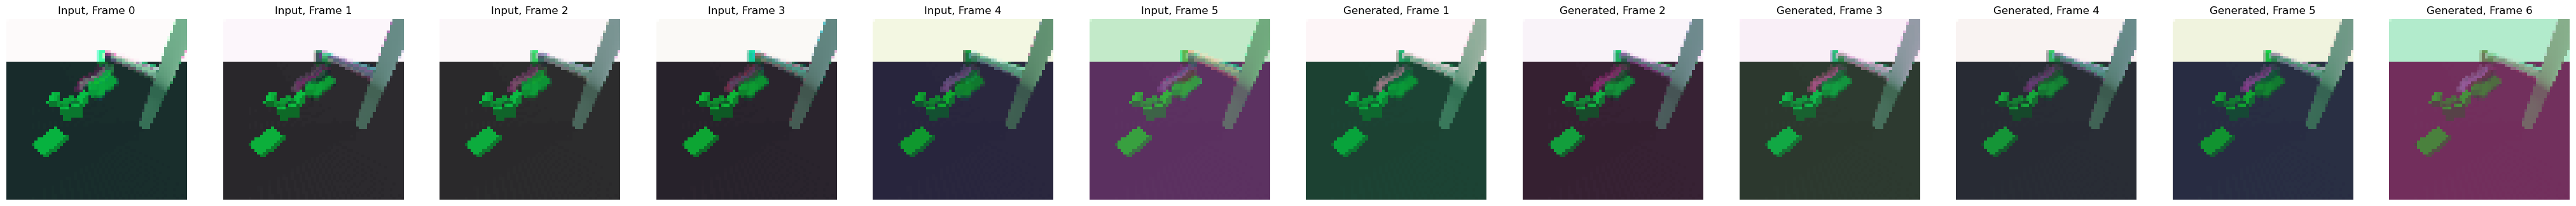

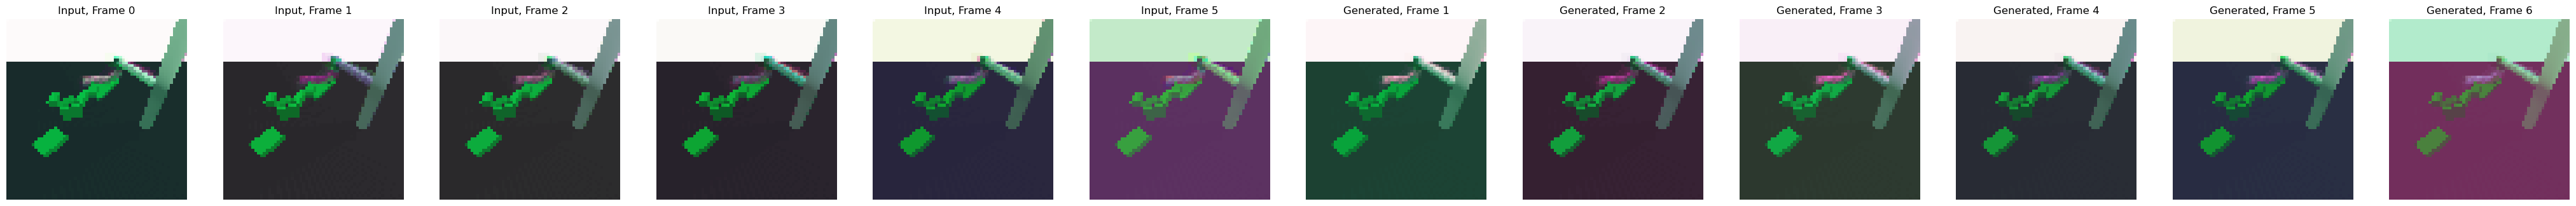

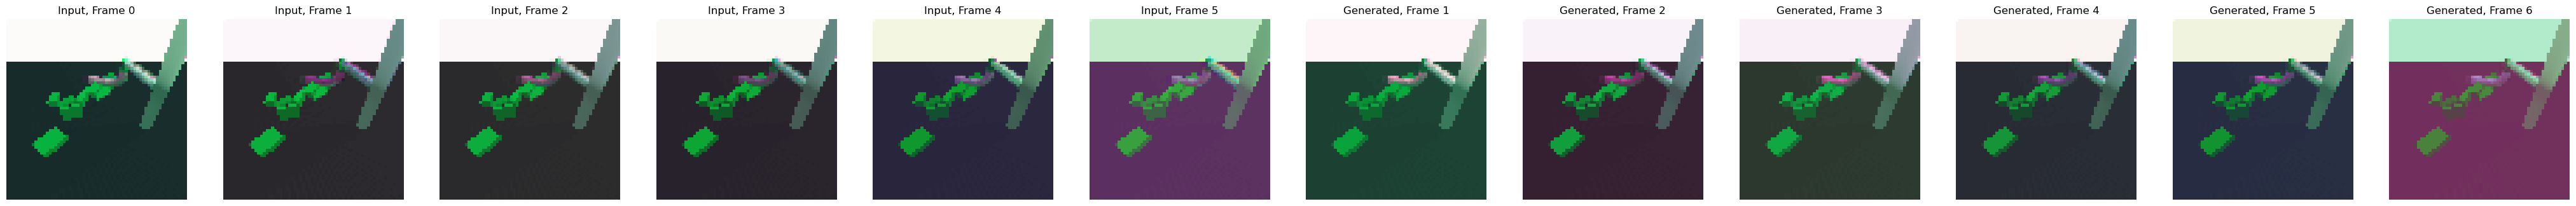

In [30]:
for i in range(2, 5):
    X = X_train[i]
    z = X_train_z[i]
    cX = cX_train[i]

    generated_images = gan.generate(X, z, cX)[0]

    gan.visualize_generated_image(generated_images, z, cX)
